# Hands on:introduction to BDT on HEP dataset

## Standard Imports

In [1]:
COLAB=True #if running on https://colab.research.google.com/notebooks/welcome.ipynb
#COLAB=False #if running on local anaconda installation https://docs.anaconda.com/anaconda/install/

#fullrun=True #if run all modules (slow!)
fullrun=False #if run a subset to get started


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython import display USEFUL ???
#from IPython.display import display, HTML
#%matplotlib inline
import time
pd.set_option('display.max_columns', 100) # to see more columns of df.head()
np.random.seed(31415) # set the np random seed for the reproducibility
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # instead of "last_expr", allow all cell output to appear 


In [3]:
# Fix environment if necessary

if COLAB:
    #!pip install xgboost --upgrade #  maybe be needed as Colab is not always uptodate
    pass
else:    
    # install xgboost and lighgbm, two popular Boosted Decision Tree packages
    # the following need to be done only once. To be commented out later
    %pip install xgboost    
    %pip install lightgbm 
    pass

import xgboost
print (xgboost.__version__) # Tested with 2.0.3  
import lightgbm
print (lightgbm.__version__) # Tested with 3.2.1
import sklearn
print (sklearn.__version__) # Tested with 1.4.2




running .zshenv
Note: you may need to restart the kernel to use updated packages.
running .zshenv
Note: you may need to restart the kernel to use updated packages.
2.0.3
3.2.1
1.4.2


In [4]:
if COLAB:
    #### Reading files from Google Drive
    # one need a google account to be identified
    # select a google account, then cut and paste the long password in the pop up field
    !pip install PyDrive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

# Load events

In [5]:
if COLAB:

    #attach dataset from google drive 
    download = drive.CreateFile({'id': '1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4'})
    download.GetContentFile("dataWW_d1_600k.csv.gz")


    datapath=""


    !ls -lrt
else :
    # make sure the file is available locally. 
    #Should be downloaded from https://drive.google.com/open?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
    %ls -lrt # what is in the local directory
    datapath="" # if in same directory (really or soft link), otherwise use proper path
    print ("Will take data from : ",datapath)

filename=os.path.join(datapath,"dataWW_d1_600k.csv.gz")
print("Will read file:",filename)
#load data
# data was created from ATLAS Open Data see doc
# http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html
dfall = pd.read_csv(filename) 

#shuffle the events, already done but just to be safe
dfall = dfall.sample(frac=1).reset_index(drop=True)
from datetime import datetime
print ("now :",datetime.now())
print ("File loaded with ",dfall.shape[0], " events ")



running .zshenv
total 20280
-rw-r--r--@ 1 rousseau  staff    17437 14 mai 16:15 logo-SOS.jpg
-rw-r--r--@ 1 rousseau  staff    21226 14 mai 16:15 higgsml_syst.py
-rw-r--r--@ 1 rousseau  staff    81894 14 mai 16:15 Save_a_copy_in_GDrive.png
-rw-r--r--@ 1 rousseau  staff     7492 14 mai 16:15 ST4PNT_ML_EI.ipynb
-rw-r--r--@ 1 rousseau  staff    42134 14 mai 16:15 SOS_Welcome_To_Colaboratory.ipynb
-rw-r--r--@ 1 rousseau  staff    42134 14 mai 16:15 SOS_Welcome_To_Colaboratory
-rw-r--r--@ 1 rousseau  staff       17 14 mai 16:15 README.md
-rw-r--r--@ 1 rousseau  staff    99627 14 mai 16:15 PreProcessingUR.ipynb
-rw-r--r--@ 1 rousseau  staff    62976 14 mai 16:15 PreProcessingMerge.ipynb
-rw-r--r--@ 1 rousseau  staff    18810 14 mai 16:15 HEPML_HandsOn_install_check.ipynb
-rw-r--r--@ 1 rousseau  staff  8946709 14 mai 16:15 HEPML_HandsOn_NN.ipynb
lrwxr-xr-x@ 1 rousseau  staff      108 14 mai 17:18 dataWW_d1_600k.csv.gz@ -> /Users/rousseau/Google Drive/Mon Drive/GD_openData/dataWW_ATLAS_openData

At this point, it should tell you "File Loaded with 600000 events". If not, it could not access the datafile, no point going further !

# Examine dataset

In [6]:
#dump list of feature
dfall.columns

Index(['eventNumber', 'label', 'met_et', 'met_phi', 'lep_n', 'lep_pt_0',
       'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1',
       'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1', 'lep_type_0',
       'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1', 'jet_eta_0', 'jet_eta_1',
       'jet_phi_0', 'jet_phi_1', 'jet_E_0', 'jet_E_1', 'mcWeight', 'runNumber',
       'channelNumber'],
      dtype='object')

In [7]:
dfall.mcWeight*=4 # arbitrary scale to have larger significance (this is a hack)

In [8]:
#examine first few events
display(dfall.head())



,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000008,284500,345323
1,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.001153,284500,363492
2,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
3,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
4,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000008,284500,345323


In [9]:
#examine feature distribution
dfall.describe()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000872,284500.0,351379.666667
std,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.002944,0.0,8564.720183
min,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.182228,284500.0,345323.000000
25%,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000008,284500.0,345323.000000
50%,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000116,284500.0,345324.000000
75%,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000786,284500.0,363492.000000
max,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.209680,284500.0,363492.000000


In [10]:
label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("total label weights  B S =",label_weights)


label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print ("total class number of events B S",label_nevents)









total label weights  B S = (498.6491778568, 24.8002135904)
total class number of events B S (200000, 400000)


## Event selection

In [11]:
print ("Df shape before selection :", dfall.shape)
# only keep events with exactly two leptons
# only keep events with positive weight. This is not correct but mandatory for a tutorial because
# many tools choke on negative weight.
fulldata=dfall[ (dfall.lep_n==2) & (dfall.mcWeight > 0)]  


print ("Df shape after selection :",fulldata.shape)



Df shape before selection : (600000, 29)
Df shape after selection : (577357, 29)



# DO NOT MODIFY ANYTHING ABOVE
... and always rerun from this cell whenever you change something below

In [12]:
#hide label and weights in separate vectors
#they are not real features

#WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = fulldata["label"]
weights = fulldata["mcWeight"]


# for simplicity of the exercise only keep some features
# this is actually making a deep copy from fulldata
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])
#data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1']

print ("Df shape of dataset to be used :",data.shape)
display(data.head())
display(target.head())
display(weights.head())



Df shape of dataset to be used : (577357, 6)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.609,0.42452,48.295,15.214,-2.316400,-1.39410
1,196.560,1.31140,69.459,21.081,0.023132,-0.67855
2,45.653,-2.76860,45.927,22.822,1.901700,-0.11248
3,49.415,-0.57805,45.929,14.263,2.254700,-2.54810
4,71.988,-2.60390,62.029,21.453,0.236200,1.40820


0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

0    0.000008
1    0.001153
2    0.000116
3    0.000116
4    0.000008
Name: mcWeight, dtype: float64

<AxesSubplot:title={'center':'Missing Transverse Energy for large lepton Pt'}, ylabel='Frequency'>

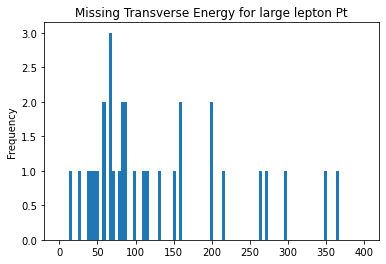

In [13]:
#data[data.met_et<1000]['met_et'].plot.hist(title='Missing Transverse Energy')
data[data.lep_pt_0+data.lep_pt_1>1000]['met_et'].plot.hist(bins=np.linspace(0,400,100),title='Missing Transverse Energy for large lepton Pt')

<Figure size 432x288 with 0 Axes>

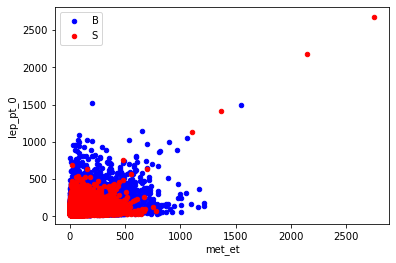

In [14]:
fig=plt.figure()
ax=data[target==0].plot.scatter(x='met_et', y='lep_pt_0',color="b",label="B")
data[target==1].plot.scatter(x='met_et', y='lep_pt_0',color="r",label="S",ax=ax)
#plt.legend(loc='best')
#ax.set_xlabel('weight*1000')
plt.show()

In [15]:
data[data.lep_pt_0+data.lep_pt_1>2000].head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
308053,2755.4,1.8538,2678.7,42.131,-1.2958,0.13151
552671,2145.7,0.3056,2180.0,30.531,-2.8257,1.50800


## Examine the weights

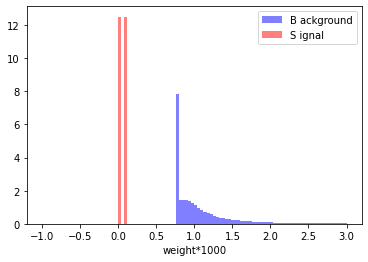

In [16]:
fig,ax=plt.subplots()
#fig=plt.figure()

bins=np.linspace(-1,3,101)
plt.hist(weights[target==0]*1000,bins=bins,color='b',alpha=0.5,density=True,label='B ackground')
plt.hist(weights[target==1]*1000,bins=bins,color='r',alpha=0.5,density=True,label='S ignal')
plt.legend(loc='best')
ax.set_xlabel('weight*1000')
plt.show()

# Some weight studies 

$s=\sum w$ for signal dataset : predicted number of signal events (luminosity, cross section, efficiencies etc... already includded in the weights). Ditto for b background. 


Effective number of events fraction : $\frac{N_{eff}}{N}= \frac{1}{1+\frac{Var(w)}{<w>^2}}$ . Example : if 0.2 it means the precision achieved with this dataset is the one which would be achieved with an unweighted dataset of 0.2 x N events (this is a rough estimate, only true for a simple counting)

In [17]:
label_n_weights=np.zeros(2)
label_sum_weights=np.zeros(2)
label_mean_weights=np.zeros(2)
label_std_weights=np.zeros(2)
label_neff_fraction=np.zeros(2)

for i in range(2):
  label_n_weights[i]=weights[target==i].size
  label_mean_weights[i]=weights[target==i].mean()
  label_std_weights[i]=weights[target==i].std()
  label_sum_weights[i]=weights[target==i].sum()
  label_neff_fraction[i]=1/(1+(label_std_weights[i]/label_mean_weights[i])**2)

print ("Weights quantities for background (target==0) and signal (target==1)")
print ("Weights sum",label_sum_weights)
print ("N events",label_n_weights)
print ("Weights mean",label_mean_weights)
print ("Weights std",label_std_weights)
print ("Weights Neff fraction",label_neff_fraction)

Weights quantities for background (target==0) and signal (target==1)
Weights sum [638.7539676  24.717593 ]
N events [180381. 396976.]
Weights mean [3.54113775e-03 6.22647037e-05]
Weights std [3.41237459e-03 5.42304678e-05]
Weights Neff fraction [0.51851137 0.56863978]


# Feature engineering
To be switched on in a second iteration

In [18]:
if False: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)
    #data["lep_deltaphi"]=data.lep_phi_1-data.lep_phi_0


    print (data.shape)
    display(data.head())
   

    



# Plot the features

<Figure size 432x288 with 0 Axes>

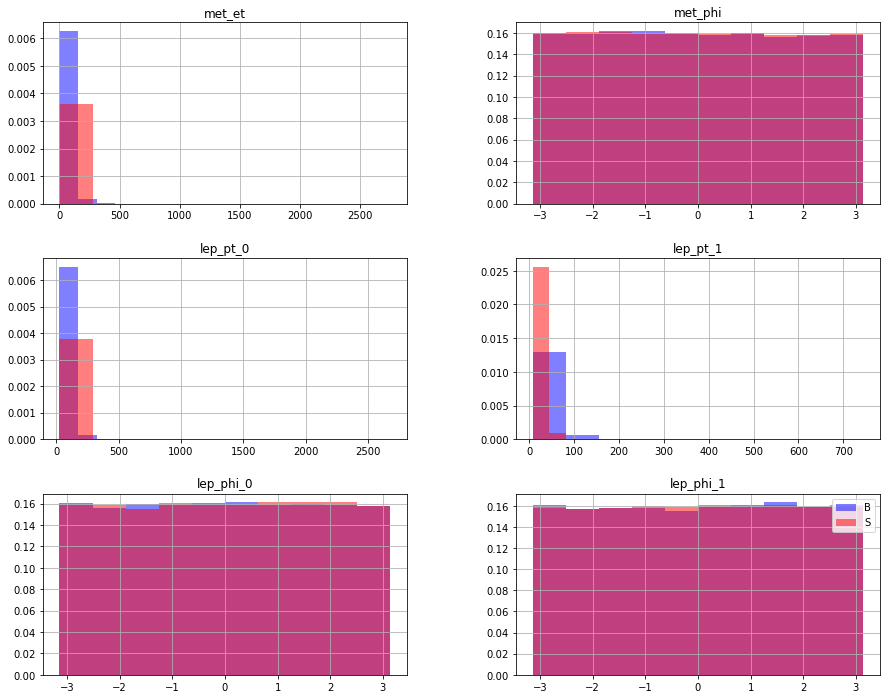

In [19]:
plt.figure()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax,label="S")


plt.legend(loc="best")
plt.show()


### Features correlation matrix

Signal feature correlation matrix


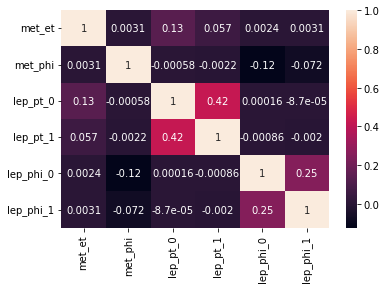

Background feature correlation matrix


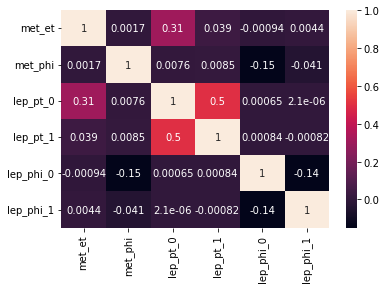

In [20]:
import seaborn as sn # seaborn for nice plot quicker
print ("Signal feature correlation matrix")
corrMatrix = data[target==1].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

print ("Background feature correlation matrix")
corrMatrix = data[target==0].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Split dataset and transform the features

In [21]:
np.random.seed(31415) # set the random seed (used for the train/test splitting)

from sklearn.model_selection import train_test_split
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
#y_train, y_test, weights_train, weights_test = \
#     y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
#    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)





# scale to mean 0 and variance 1
# not really needed for BDT but we never know
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #calculate and apply the transformation to training dataset
X_test = scaler.transform(X_test)  # apply to test dataset the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)): # loop on B then S target
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 

print ("Weights have been normalised to a given number of proton collision")    
print ("Orig : total weight sig", weights[target == 1].sum())
print ("Orig : total weight bkg", weights[target == 0].sum())


print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())


    

(433017, 6)
(433017,)
(433017,)
(144340, 6)
(144340,)
(144340,)
Weights have been normalised to a given number of proton collision
Orig : total weight sig 24.717592998400008
Orig : total weight bkg 638.7539675983998
Test : total weight sig 24.717773318400006
Test : total weight bkg 635.6988284976001
Train : total weight sig 479.8292604740002
Train : total weight bkg 479.82926047399997


In [22]:
weights_train

573199    0.000786
555170    0.000992
293648    0.000208
45786     0.001094
496975    0.000208
            ...   
559129    0.003015
3835      0.000208
559453    0.000208
415151    0.000208
297320    0.003015
Name: mcWeight, Length: 433017, dtype: float64

In [23]:
weights_train.reset_index()

,index,mcWeight
0,573199,0.000786
1,555170,0.000992
2,293648,0.000208
3,45786,0.001094
4,496975,0.000208
...,...,...
433012,559129,0.003015
433013,3835,0.000208
433014,559453,0.000208
433015,415151,0.000208


# Testing BDT

## Load significance function

In [24]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov significance arXiv:1007.1727 eq. 97
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(b)


## XGBoost

In [25]:
np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0

# creates the classifier
xgb = XGBClassifier()

starting_time = time.time()

# does the real work

xgb.fit(X_train, y_train.values, sample_weight=weights_train) # note that XGB 1.3.X and higher requires positive weight
        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1]

auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
print("auc test:",auc_test_xgb)

print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,sample_weight=weights_train))

# compute significance
int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)

Z = significance_xgb
print("Z:",Z)

Training time: 0.7783389091491699
auc test: 0.8670325891921841
auc train: 0.8754233529441572
Z: 1.6238458364767834


In [26]:
xgb.predict_proba(X_train)[:,1]

array([0.07188293, 0.47251457, 0.7261075 , ..., 0.86929744, 0.718722  ,
       0.65342396], dtype=float32)

In [27]:
print("auc test",roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test))
print("auc test without weights",roc_auc_score(y_true=y_test, y_score=y_pred_xgb))





auc test 0.8670325891921841
auc test without weights 0.8677920695009682


## LightGBM

In [29]:
np.random.seed(31415) # set the random seed

import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0

gbm = lgb.LGBMClassifier()

starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train)

training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1]
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm,sample_weight=weights_test)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,sample_weight=weights_train))

#compute significance
int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
Z = significance_gbm
print("Z:",Z)




Training time: 0.7550499439239502
auc test: 0.8296102251691393
auc train: 0.8379442181132511
Z: 1.4217297300407892


## SKLearn GBDT

In [30]:
from sklearn import ensemble

skgb=ensemble.HistGradientBoostingClassifier()


starting_time = time.time( )

skgb.fit(X_train, y_train.values,sample_weight=weights_train)


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_skgb = skgb.predict_proba(X_test)[:,1]
y_pred_skgb = y_pred_skgb.ravel()
y_pred_train_skgb = skgb.predict_proba(X_train)[:,1]
auc_test_skgb = roc_auc_score(y_true=y_test, y_score=y_pred_skgb,sample_weight=weights_test)
print("auc test:",auc_test_skgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_skgb,sample_weight=weights_train))

#compute significance
int_pred_test_sig_skgb = [weights_test[(y_test ==1) & (y_pred_skgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_skgb = [weights_test[(y_test ==0) & (y_pred_skgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov_skgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_skgb,int_pred_test_bkg_skgb)]
significance_skgb = max(vamsasimov_skgb)
Z = significance_skgb
print("Z:",Z)





Training time: 2.2672598361968994
auc test: 0.8473429113208336
auc train: 0.8558127934697892
Z: 1.5091731717352366


In [31]:
print('Best significance found are:')
print('XGBoost : ', significance_xgb)
print('LightGBM: ', significance_gbm)
print('sklearn: ', significance_skgb)


print('Best auc test found are:')
print('XGBoost: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_xgb,sample_weight=weights_test)) 
print('LightGBM: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_gbm,sample_weight=weights_test))
print('sklearn: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_skgb,sample_weight=weights_test))

Best significance found are:
XGBoost :  1.6238458364767834
LightGBM:  1.4217297300407892
sklearn:  1.5091731717352366
Best auc test found are:
XGBoost:  0.8670325891921841
LightGBM:  0.8296102251691393
sklearn:  0.8473429113208336


# Some nice plots 

## load score plotting function

In [32]:
# some utilities
from math import sqrt
from math import log

# Plot score for signal and background, comparing training and testing
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), 
                       bins=30,xlabel="", ylabel="Arbitrary units", title="", 
                       weights_train=np.array([]), weights_test=np.array([]),
                       density=True):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=density, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')




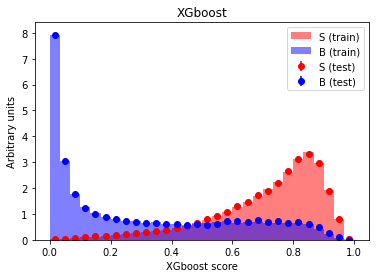

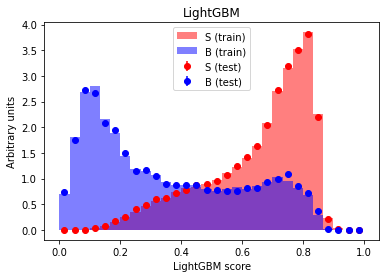

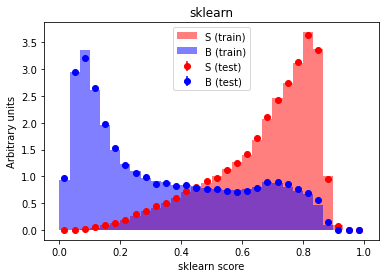

In [33]:
compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, 
                   xlabel="XGboost score", title="XGboost", 
                   weights_train=weights_train.values, weights_test=weights_test.values)
plt.savefig("Score_BDT_XGBoost_Hist.pdf")
plt.show()
compare_train_test(y_pred_train_gbm, y_train, y_pred_gbm, y_test, 
                   xlabel="LightGBM score", title="LightGBM", 
                   weights_train=weights_train.values, weights_test=weights_test.values)
plt.savefig("Score_BDT_LightGBM.pdf")
plt.show()
compare_train_test(y_pred_train_skgb, y_train, y_pred_skgb, y_test, 
                   xlabel="sklearn score", title="sklearn", 
                   weights_train=weights_train.values, weights_test=weights_test.values)
plt.savefig("Score_BDT_sklearn.pdf")
plt.show()

## Plot without renormalising

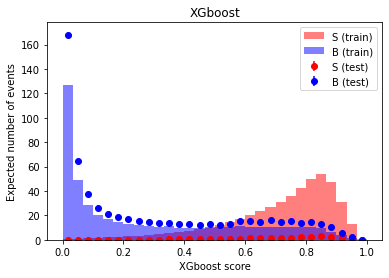

In [34]:
compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, 
                   xlabel="XGboost score", ylabel="Expected number of events", title="XGboost", 
                   weights_train=weights_train.values, weights_test=weights_test.values, 
                   density=False)
plt.show()



## ROC curve

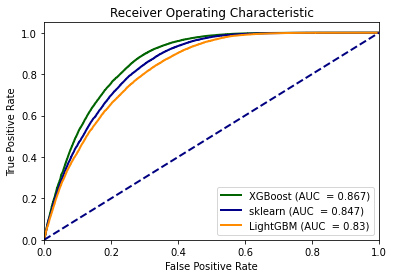

In [35]:
from sklearn.metrics import roc_curve
lw = 2

fpr_xgb,tpr_xgb,_ = roc_curve(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test.values)
fpr_gbm,tpr_gbm,_ = roc_curve(y_true=y_test, y_score=y_pred_gbm,sample_weight=weights_test.values)
fpr_skgb,tpr_skgb,_ = roc_curve(y_true=y_test, y_score=y_pred_skgb,sample_weight=weights_test.values)


plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=3)))
plt.plot(fpr_skgb, tpr_skgb, color='darkblue',lw=lw, label='sklearn (AUC  = {})'.format(np.round(auc_test_skgb,decimals=3)))
plt.plot(fpr_gbm, tpr_gbm, color='darkorange',lw=lw, label='LightGBM (AUC  = {})'.format(np.round(auc_test_gbm,decimals=3)))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC_comparing.pdf")
plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

## Significance curve

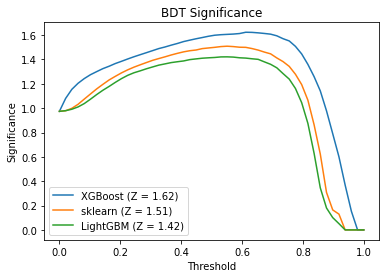

In [36]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb,decimals=2)))
plt.plot(np.linspace(0,1,num=50),vamsasimov_skgb, label='sklearn (Z = {})'.format(np.round(significance_skgb,decimals=2)))
plt.plot(np.linspace(0,1,num=50),vamsasimov_gbm, label='LightGBM (Z = {})'.format(np.round(significance_gbm,decimals=2)))



plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_comparing.pdf")
plt.show()

# More advanced

# Hyper Parameter Optimisation
Can be done by hand or with [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) .

Best parameters :  {'learning_rate': 0.1533499951503625, 'max_depth': 7, 'n_estimators': 402}
Best score (on train dataset CV) :  0.8696267194849465
... corresponding score on test dataset :  0.8712618557732413


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,3.320168,0.193278,0.693159,0.017669,0.437587,8,724,"{'learning_rate': 0.43758708492566745, 'max_de...",0.864948,0.864355,0.864651,0.000296,8
1,2.581668,0.454205,0.620207,0.008186,0.542402,9,527,"{'learning_rate': 0.5424021821532976, 'max_dep...",0.863544,0.863439,0.863491,0.000052,9
2,3.424669,0.052299,0.773891,0.002583,0.511796,9,668,"{'learning_rate': 0.511796483168885, 'max_dept...",0.863527,0.862719,0.863123,0.000404,10
3,2.193817,0.435125,0.301065,0.001042,0.28207,6,466,"{'learning_rate': 0.28207044766661693, 'max_de...",0.869197,0.869213,0.869205,0.000008,4
4,1.979742,0.102095,0.498575,0.001849,0.350171,9,417,"{'learning_rate': 0.3501705954790827, 'max_dep...",0.867118,0.866928,0.867023,0.000095,7
5,1.778984,0.009331,0.332846,0.003623,0.15335,7,402,"{'learning_rate': 0.1533499951503625, 'max_dep...",0.869691,0.869562,0.869627,0.000064,1
6,2.063359,0.213567,0.283199,0.009349,0.350582,5,563,"{'learning_rate': 0.3505821137468814, 'max_dep...",0.868778,0.868622,0.868700,0.000078,6
7,2.173446,0.117764,0.387771,0.003324,0.257818,6,427,"{'learning_rate': 0.2578181438060201, 'max_dep...",0.869527,0.869163,0.869345,0.000182,2
8,2.342543,0.000636,0.644970,0.011281,0.199914,11,303,"{'learning_rate': 0.19991409178478245, 'max_de...",0.868899,0.869085,0.868992,0.000093,5
9,3.247482,0.225451,0.912145,0.020872,0.151123,11,479,"{'learning_rate': 0.15112289093118267, 'max_de...",0.869300,0.869136,0.869218,0.000082,3


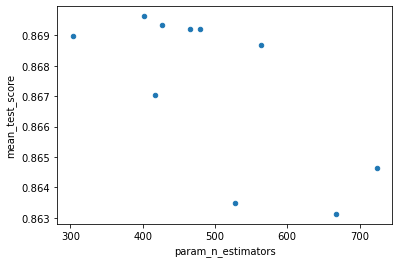

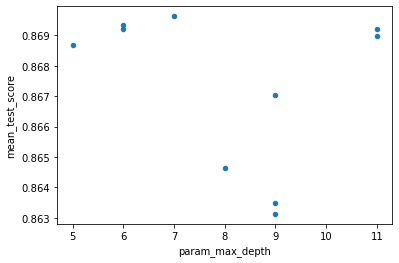

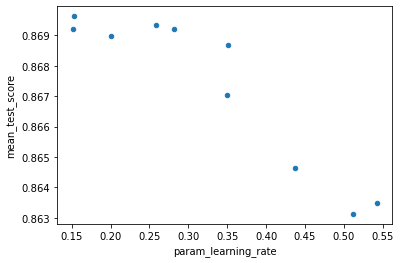

In [37]:
#RandomSearchCV for advanced HPO 
import scipy.stats as stats
if fullrun or False:
    from sklearn.model_selection import RandomizedSearchCV

    # specify parameters and distributions to sample from
    param_dist_XGB = {'max_depth': stats.randint(3, 12), # default 6
                      'n_estimators': stats.randint(300, 800), #default 100
                      'learning_rate': stats.uniform(0.1, 0.5)} #def 0.3 

    # default CV is 5 fold, reduce to 2 for speed concern
    gsearch = RandomizedSearchCV(estimator = XGBClassifier(), 
                        param_distributions = param_dist_XGB, 
                        scoring='roc_auc',n_iter=10,cv=2)
    gsearch.fit(X_train,y_train, sample_weight=weights_train)

    print ("Best parameters : ",gsearch.best_params_)
    print ("Best score (on train dataset CV) : ",gsearch.best_score_)


    y_pred_gs = gsearch.predict_proba(X_test)[:,1]
    print("... corresponding score on test dataset : ",roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test))
    dfsearch=pd.DataFrame.from_dict(gsearch.cv_results_)
    display(dfsearch)
    
    dfsearch.plot.scatter("param_n_estimators","mean_test_score")
    dfsearch.plot.scatter("param_max_depth","mean_test_score")
    dfsearch.plot.scatter("param_learning_rate","mean_test_score")


# Learning Curve
This could be done with sklearn  [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html).
However (last time I checked) : it does not handle weights, it does not allow to control testing dataset size

Exercise left to the reader : look at significance rather than auc

Exercise left to the reader : look separately at performance versus number of signal event and number of background events.



training with  4330  events
training with  21650  events
training with  43301  events
training with  86603  events
training with  216508  events
training with  324762  events
training with  433017  events


,Ntraining,test_auc,train_auc,time
0,4330,0.743953,0.763694,0.039038
1,21650,0.839037,0.858753,0.091515
2,43301,0.854853,0.874616,0.144123
3,86603,0.862202,0.880502,0.252811
4,216508,0.866470,0.878472,0.502414
5,324762,0.866490,0.876924,0.822221
6,433017,0.867033,0.875423,0.777540


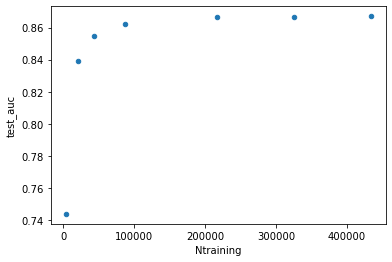

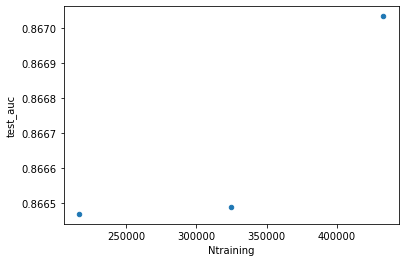

In [42]:
#example with sklearn (but without weights and with no fixed test dataset)
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     XGBClassifier(),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)

if fullrun or False : 
    train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
    ntrains=[]
    test_aucs=[]
    train_aucs=[]
    times=[]

    xgb = XGBClassifier()
    
    for train_size in train_sizes:
      ntrain=int(len(X_train)*train_size)
      print("training with ",ntrain," events")
      ntrains+=[ntrain]
      starting_time = time.time()

      # train using the first ntrain event of the training dataset
      xgb.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
      training_time = time.time( ) - starting_time
      times+=[training_time]

      # score on test dataset (always the same)
      y_pred_xgb=xgb.predict_proba(X_test)[:,1]
      auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
      test_aucs+=[auc_test_xgb]

      # score on the train dataset 
      y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
      auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb,sample_weight=weights_train[:ntrain])
      train_aucs+=[auc_train_xgb]

    dflearning=pd.DataFrame({"Ntraining":ntrains,
                             "test_auc":test_aucs,
                             "train_auc":train_aucs,
                             "time":times})
    display(dflearning)

    dflearning.plot.scatter("Ntraining","test_auc")
    # focus on the last point
    dflearning[4:].plot.scatter("Ntraining","test_auc")

# Feature importance
Feature importance allows to display the importance of each feature without rerunnning the training. It is obtained from internal algorithm quantities, like number of time a feature is used to definea leaf. Magnitude is arbitrary. It can be used as a not very reliable indication of which feature is the most discriminant.

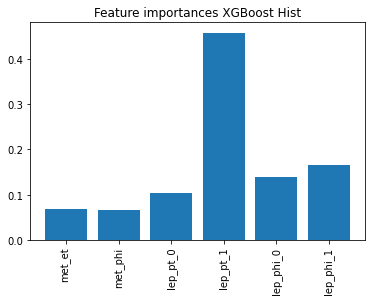

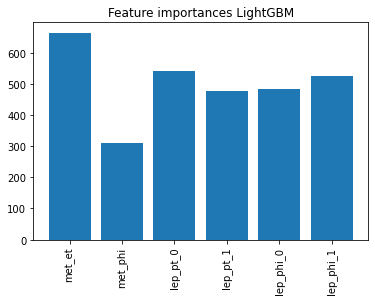

In [39]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
#plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
plt.show()
plt.bar(data.columns.values, gbm.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
#plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
plt.show()


# Permutation importance

A better way to show the importance of each feature is Permutation Importance, where each feature in turn is replaced by an instance of an other event (effectively switching it off by randomising).
In particular it allows to : 
   * display directly the loss in whatever criteria (ROC auc, asimov significance) when the feature is switched off
   * display the feature importance for a specific subset (for example the most signal like)
   * it can even display which feature has the larges impact on systematics


However, report can be misleading in case of highly correlated variables. 
   


In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train.values, sample_weight=weights_train) # note that XGB 1.3.X and higher requires positive weight

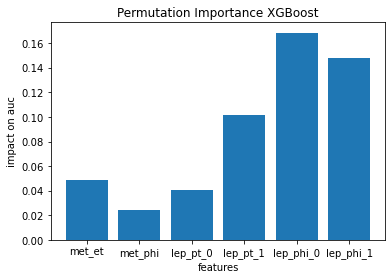

In [56]:
if fullrun or False:
    from sklearn.inspection import permutation_importance
    #WARNING interesting feature in permutation_importance, need to ravel label and test vectors
    r = permutation_importance(xgb, X_test.copy(), y_test.ravel(),sample_weight=weights_test.ravel(),
                           scoring='roc_auc',n_repeats=1,n_jobs=-1,
                            random_state=0)
    plt.bar(data.columns,r.importances.mean(axis=1).T,)

    plt.xlabel('features')
    plt.ylabel('impact on auc')
    plt.title('Permutation Importance XGBoost')

    plt.show()

##  Model serialisation
It is useful to be able to save a model in order to apply it without retraining. There are many ways to do it. One is to save the whole python object with joblib (beware this is not safe if the software evolves). Another is to used dedicated serialisation like the one proposed by xgboost.


In [45]:
#WARNING : StandardScaler has not been saved, it should be for the complete model to be saved
if fullrun or False:
    print( "will print xgb performance directly after fit, after serialising with xgb api, after serialising with joblib. Should be identical")
    import joblib
    myxgb = XGBClassifier()
    myxgb.fit(X_train, y_train, sample_weight=weights_train)

    auc_test_xgb = roc_auc_score(y_true=y_test, y_score=myxgb.predict_proba(X_test)[:,1],sample_weight=weights_test)
    print ("myxgb score",auc_test_xgb)
 
    # save model with xgb api
    myxgb.save_model("XGBoost.json")

    # save python object
    joblib.dump(myxgb, "myxgb.dat")


    del myxgb # delete xgb object, just to be sure

    # reload model from XGB API
    myxgb_reloaded_from_model =XGBClassifier()
    myxgb_reloaded_from_model.load_model("XGBoost.json")
    print ("myxgb reloaded from model",
           roc_auc_score(y_true=y_test, 
                         y_score=myxgb_reloaded_from_model.predict_proba(X_test)[:,1],sample_weight=weights_test)
          )


    # reload object from joblib
    myxgb_reloaded_from_joblib=joblib.load("myxgb.dat")
    print ("myxgb reloaded from object",
           roc_auc_score(y_true=y_test, 
                         y_score=myxgb_reloaded_from_joblib.predict_proba(X_test)[:,1],sample_weight=weights_test)
          )
    # dump json file
    #!python -m json.tool XGBoost.json







will print xgb performance directly after fit, after serialising with xgb api, after serialising with joblib. Should be identical
myxgb score 0.8670325891921841
myxgb reloaded from model 0.8670325891921841
myxgb reloaded from object 0.8670325891921841
